In [2]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import yfinance as yf
from ts2vg import NaturalVG, HorizontalVG
import networkx as nx
from tqdm import tqdm
from scipy.spatial import distance
import neurokit2 as nk

In [3]:
#plt.style.use(['science', 'notebook', 'grid'])
plt.style.use(['classic'])
plt.rcParams.update({'legend.fontsize': 26})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['font.size'] = '26'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['savefig.dpi'] = 300
xlabel = 'strain'

In [4]:
def recurrence_net(time_ser, rec_thr, dim, tau, dist_type='euclidien'):
    time_series = nk.complexity_embedding(time_ser, dimension=dim, delay=tau)
    rp = (distance.cdist(time_series, time_series, dist_type) <= rec_thr).astype(int)
    adj_matrix_RN = rp
    np.fill_diagonal(adj_matrix_RN, 0)

    rec_nw = nx.from_numpy_matrix(adj_matrix_RN)
    
    return rec_nw

def node_positions_recurrence_net(ts, xs):
    return {i: (xs[i], ts[i]) for i in range(len(ts))}

# Зчитування з Yahoo Finance

In [ ]:
symbol = "^DJI"
symbol_for_graph = "^DJI"
data = yf.download(symbol)
time_ser = data['Adj Close'].copy()
for_graph = data['Adj Close'].copy()

date_in_num = mdates.date2num(time_ser.index)

np.savetxt(f'{symbol}_initial_time_series.txt', time_ser.values)

# Зчитування з txt файлів

In [5]:
symbol = "sMpa11.txt" #назва файлу 1, що зчитуємо

In [6]:
with open(symbol, 'r') as f: #зчитуємо файл
    time_ser = [line.strip('\n') for line in f.readlines()]
    time_ser = [float(line) for line in time_ser if line != '']
time_ser = pd.Series(time_ser) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень
date_in_num = time_ser.index 

In [7]:
symbol_for_graph = "Mpa11.txt" #для графіки

In [8]:
with open(symbol_for_graph, 'r') as f_for_graph: #зчитуємо файл
    for_graph = [line.strip('\n') for line in f_for_graph.readlines()]
    for_graph = [float(line) for line in for_graph if line != '']
for_graph = pd.Series(for_graph) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

# Виведення графіку досліджуваного ряду

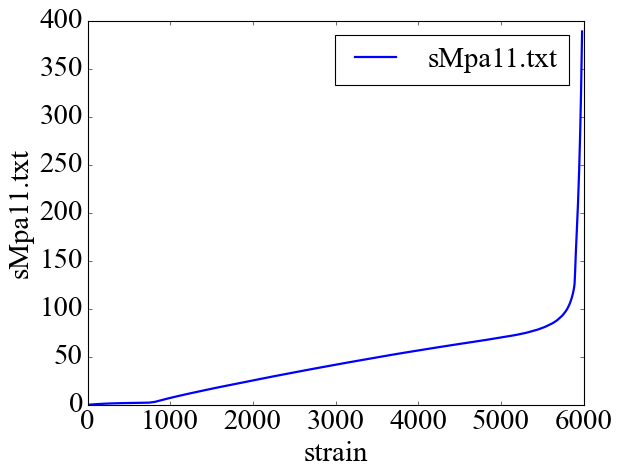

In [9]:
fig, ax = plt.subplots()
time_ser.plot(figsize=(8,6), xlabel=xlabel, ylabel=symbol)
ax.legend([symbol]);

plt.savefig(f'{symbol}.jpg')
plt.show()

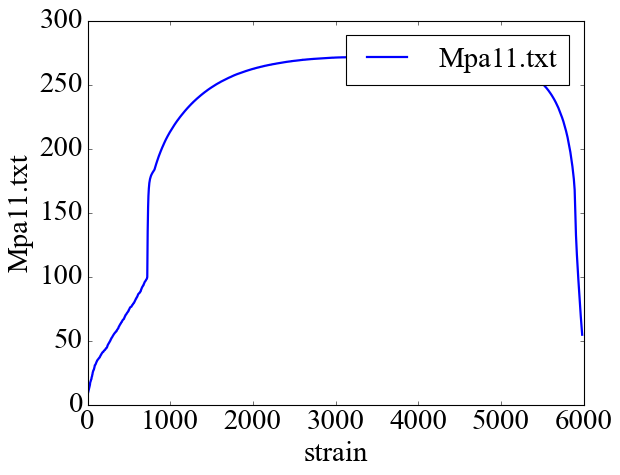

In [10]:
fig, ax = plt.subplots()
for_graph.plot(figsize=(8,6), xlabel=xlabel, ylabel=symbol_for_graph)
ax.legend([symbol_for_graph]);

plt.savefig(f'{symbol_for_graph}.jpg')
plt.show()

# Задання параметрів досліджуваного графу

In [67]:
window = 150 #розмір вікна
tstep = 25 #крок вікна
graph_type = 'classic' # тип графу: classic, horizontal, recurrent

ret_type = 1 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності)
                        # 6 - стандартизований ряд


# Для рекурентного графа 
d_e = 3 # розмірність
tau = 1 # часова затримка
eps = 1.3 # радіус
dist = 'chebyshev' # canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
                   # ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, 
                   # ‘jensenshannon’, ‘kulsinski’, ‘kulczynski1’, ‘mahalanobis’, 
                   # ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, 
                   # ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

length = len(time_ser)

# Побудова графу

In [12]:
index_begin = 500
index_end = 2000

for_graph_plot = time_ser.copy()

if ret_type == 1:
    pass
elif ret_type == 2:
    for_graph_plot = for_graph_plot.diff()
elif ret_type == 3:
    for_graph_plot = for_graph_plot.pct_change()
elif ret_type == 4:
    for_graph_plot = for_graph_plot.pct_change()
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()
elif ret_type == 5: 
    for_graph_plot = for_graph_plot.pct_change()
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()
    for_graph_plot = for_graph_plot.abs()
elif ret_type == 6:
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()

for_graph_plot = for_graph_plot.copy().dropna().values

date = date_in_num[index_begin:index_end]

if graph_type == 'classic':
    g = NaturalVG(directed=None).build(for_graph_plot[index_begin:index_end], xs=date)
    pos = g.node_positions()
    nxg = g.as_networkx()
elif graph_type == 'horizontal':
    g = HorizontalVG(directed=None).build(for_graph_plot[index_begin:index_end], xs=date)
    pos = g.node_positions()
    nxg = g.as_networkx()
else:
    g = recurrence_net(for_graph_plot[index_begin:index_end], 
                       rec_thr=eps * np.abs(np.std(for_graph_plot[index_begin:index_end])), 
                       dim=d_e, 
                       tau=tau, 
                       dist_type=dist)
    
    pos = node_positions_recurrence_net(for_graph_plot[index_begin:index_end], date)
    nxg = g
    
    


graph_plot_options = {
    'with_labels': False,
    'node_size': 2,
    'node_color': [(0, 0, 0, 1)],
    'edge_color': [(0, 0, 0, 0.15)],
}


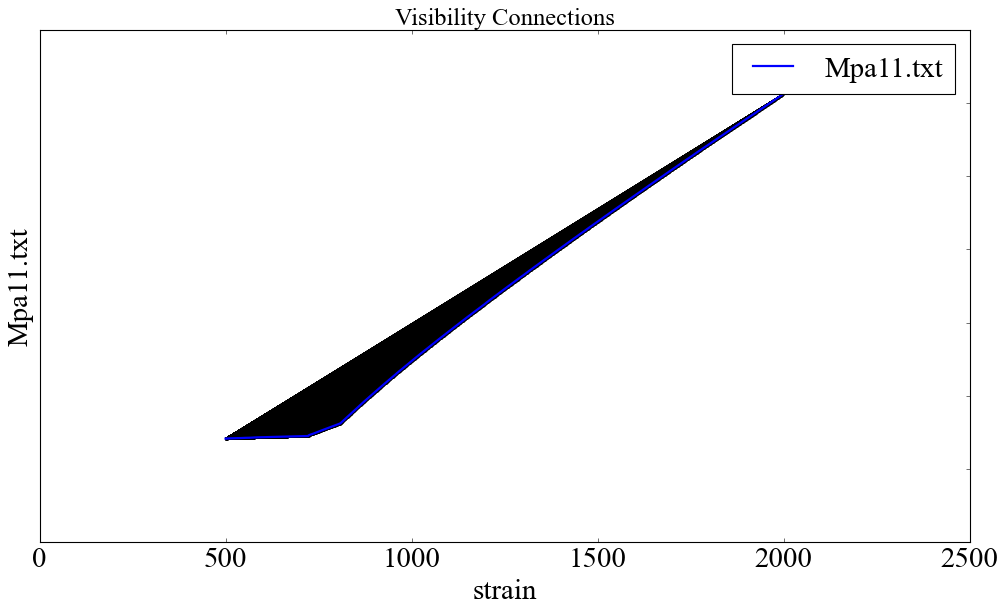

In [13]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

nx.draw_networkx(nxg, ax=ax1, pos=pos, **graph_plot_options)
ax1.tick_params(bottom=True, labelbottom=True)
ax1.plot(time_ser.index[index_begin:index_end], for_graph_plot[index_begin:index_end], label=fr"{symbol_for_graph}")
ax1.set_title('Visibility Connections', fontsize=22)
ax1.set_xlabel(xlabel)
ax1.set_ylabel(fr"{symbol_for_graph}")
ax1.legend(loc='upper right')

plt.savefig(f"Time_ser_connections_symbol={symbol}_idx_beg={index_begin}_idx_end={index_end}_sertype={ret_type}_network_type={graph_type}.jpg", bbox_inches="tight")
plt.show()

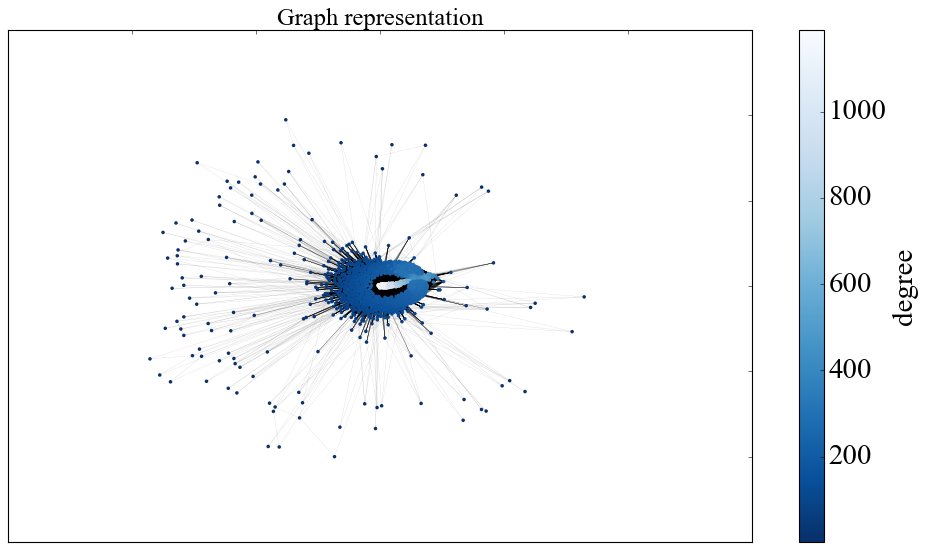

In [14]:
pos = nx.spring_layout(nxg,k=0.15,iterations=100)
# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos: #helps in color code nodes
    x, y = pos[n]
    d = (x - 0.5)**2 + (y - 0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

#color by degree
p = dict(nx.degree(nxg))
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax2.set_title('Graph representation', fontsize=22)
nx.draw_networkx_edges(nxg, ax=ax2, pos=pos, nodelist=[ncenter], alpha=0.4,width=0.1)
nx.draw_networkx_nodes(nxg, ax=ax2, pos=pos, nodelist=list(p.keys()),
                       node_size=10, edgecolors='r', linewidths=0.01,
                       node_color=list(p.values()),
                       cmap=plt.cm.Blues_r)
        
vmin = np.asarray(list(p.values())).min()
vmax = np.asarray(list(p.values())).max()

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues_r, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = plt.colorbar(sm, ax=ax2)
cb.set_label('degree')
#sm.set_array([])
#plt.axis('off')

plt.savefig(f"Graph_representation_symbol={symbol}_idx_beg={index_begin}_idx_end={index_end}_sertype={ret_type}_network_type={graph_type}.jpg", bbox_inches="tight")
plt.show()

# In window (Spectral)

In [15]:
AlgebraicCon = []
GraphEnergy = []
SpecMoment_3 = []
SpecRadius = []
SpecGap = []
NaturalConnectivity = []

In [16]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    
    adj_spectrum = np.float64(nx.adjacency_spectrum(nxg)) # спектр власних значень матриці суміжності
    sorted_adj_spectrum = np.sort(adj_spectrum)
    
    alg_con = nx.algebraic_connectivity(nxg, normalized=True, method='tracemin_lu') 
    graph_en = np.sum(np.abs(adj_spectrum))
    spec_gap = sorted_adj_spectrum[-1] - sorted_adj_spectrum[-2]
    spec_rad = np.max(np.abs(adj_spectrum))
    spec_mom_3 = np.mean(adj_spectrum ** 3)
    nat_con = np.log(np.mean(np.exp(adj_spectrum)))
    
    
    AlgebraicCon.append(alg_con)
    GraphEnergy.append(graph_en)
    SpecRadius.append(spec_rad)
    SpecGap.append(spec_gap)
    SpecMoment_3.append(spec_mom_3)
    NaturalConnectivity.append(nat_con)

  0%|          | 0/230 [00:00<?, ?it/s]C:\Users\Andrii\anaconda3\lib\site-packages\networkx\linalg\spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())
C:\Users\Andrii\AppData\Local\Temp\ipykernel_12460\1692472099.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  adj_spectrum = np.float64(nx.adjacency_spectrum(nxg)) # спектр власних значень матриці суміжності
<class 'networkx.utils.decorators.argmap'> compilation 21:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|██████████| 230/230 [00:19<00:00, 11.87it/s]


In [17]:
np.savetxt(f"algebraic_conn_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AlgebraicCon)
np.savetxt(f"graph_energy_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GraphEnergy)
np.savetxt(f"spectral_radius_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", SpecRadius)
np.savetxt(f"spectral_grap_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", SpecGap)
np.savetxt(f"spectral_moment_3_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", SpecMoment_3)
np.savetxt(f"natural_connectivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", NaturalConnectivity)

In [18]:
Alg_con = np.asarray(AlgebraicCon).reshape(-1, 1)
Graph_en = np.asarray(GraphEnergy).reshape(-1, 1)
Spec_rad = np.asarray(SpecRadius).reshape(-1, 1)
Spec_gap = np.asarray(SpecGap).reshape(-1, 1)
Spec_mom_3 = np.asarray(SpecMoment_3).reshape(-1, 1)
Natural_conn = np.asarray(NaturalConnectivity).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_Alg_con = min_max_scaler.fit_transform(Alg_con)
scaled_Graph_en = min_max_scaler.fit_transform(Graph_en)
scaled_Spec_rad = min_max_scaler.fit_transform(Spec_rad)
scaled_Spec_gap = min_max_scaler.fit_transform(Spec_gap)
scaled_Spec_mom_3 = min_max_scaler.fit_transform(Spec_mom_3)
scaled_Natural_connectivity = min_max_scaler.fit_transform(Natural_conn)

scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

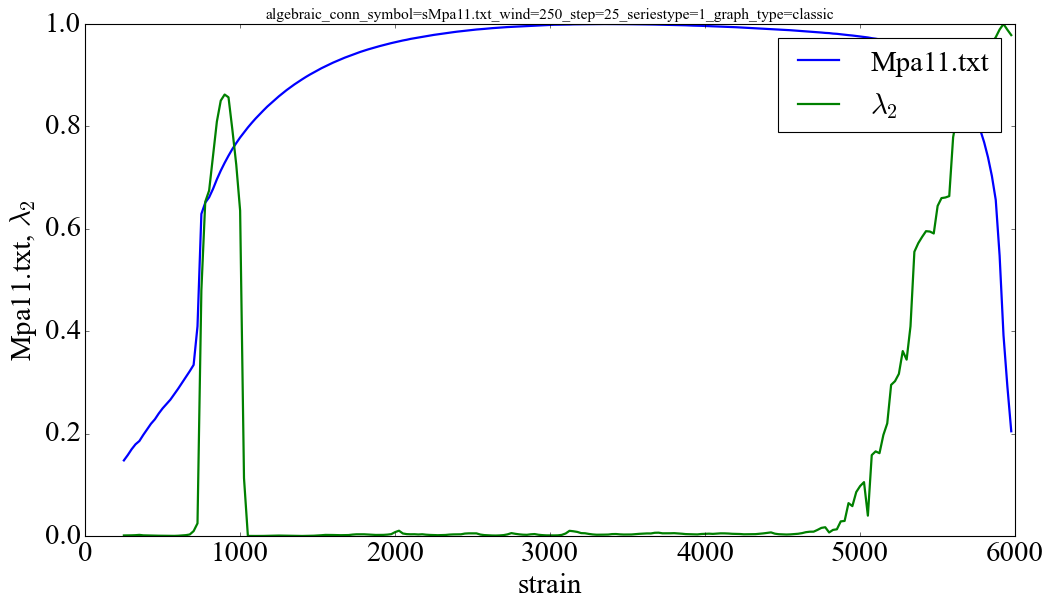

In [19]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Alg_con, label=r'$\lambda_{2}$')
ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph}, $\lambda_{2}$")
ax.set_title(f"algebraic_conn_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"algebraic_conn, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

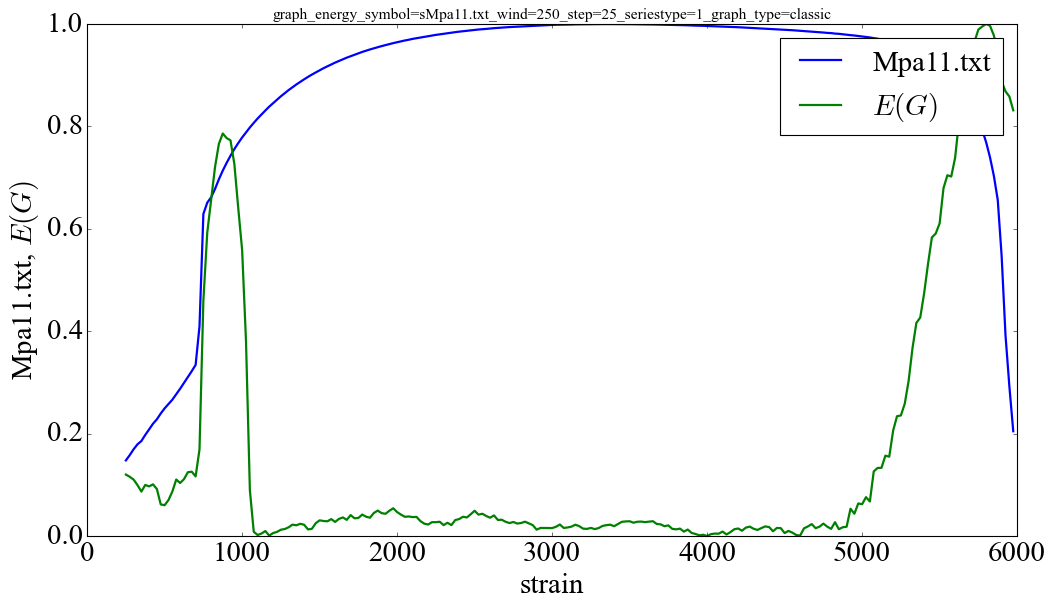

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Graph_en, label=r'$E(G)$')
ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph}, $E(G)$")
ax.set_title(f"graph_energy_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"graph_energy, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

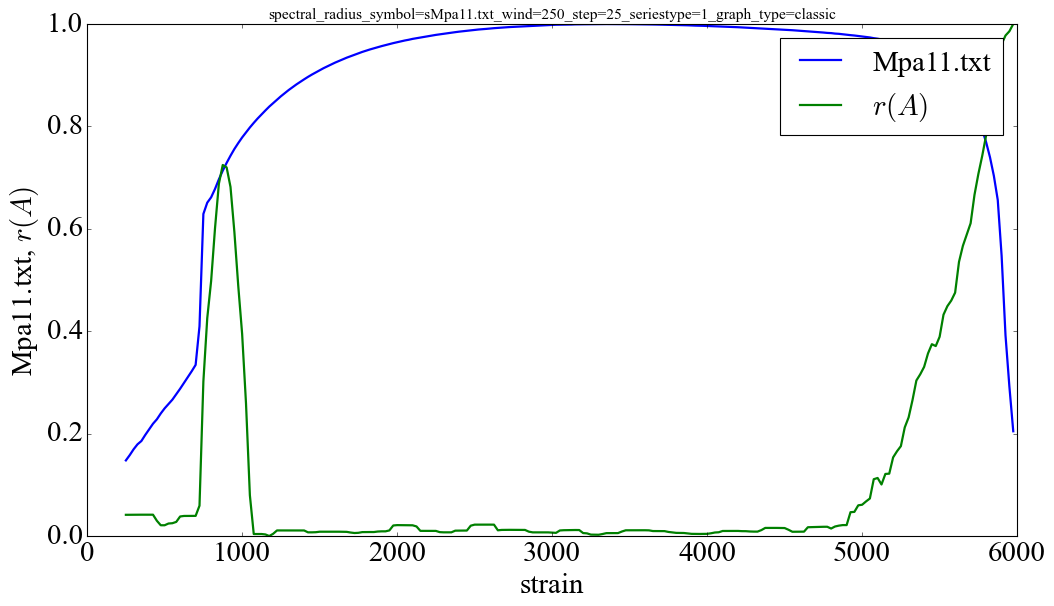

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Spec_rad, label=r'$r(A)$')
ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph}, $r(A)$")
ax.set_title(f"spectral_radius_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"spectral_radius, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

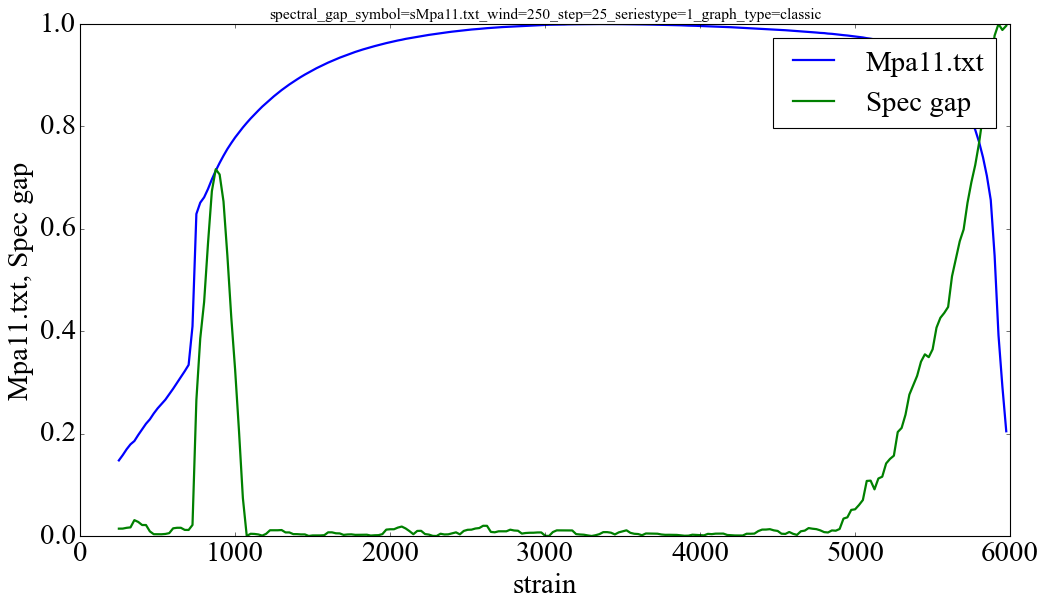

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Spec_gap, label='Spec gap')
ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph}, Spec gap")
ax.set_title(f"spectral_gap_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"spectral_gap, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

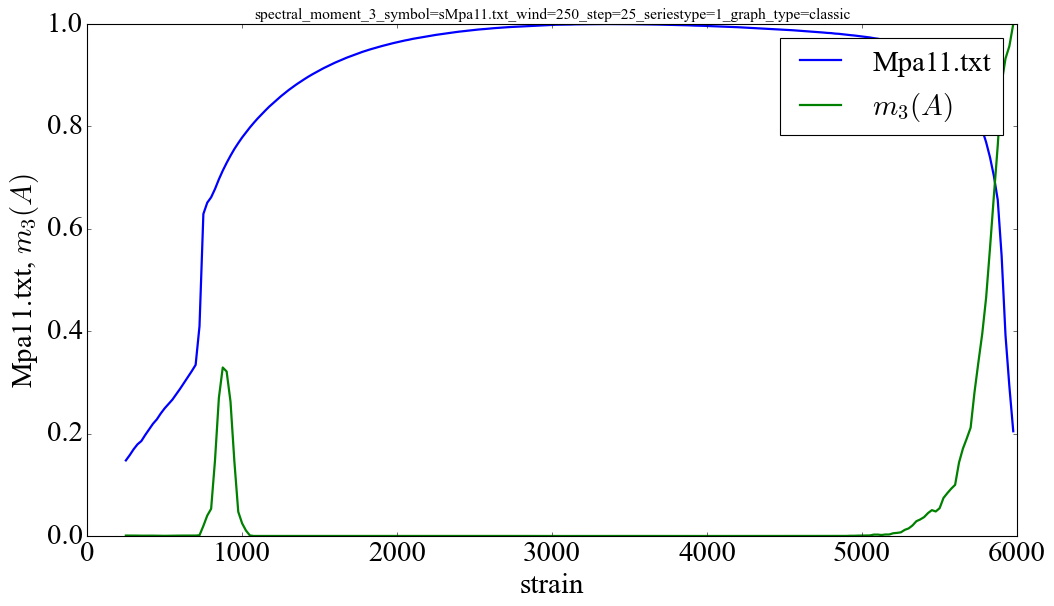

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Spec_mom_3, label=r'$m_{3}(A)$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$m_{3}(A)$")
ax.set_title(f"spectral_moment_3_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"spectral_moment_3, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

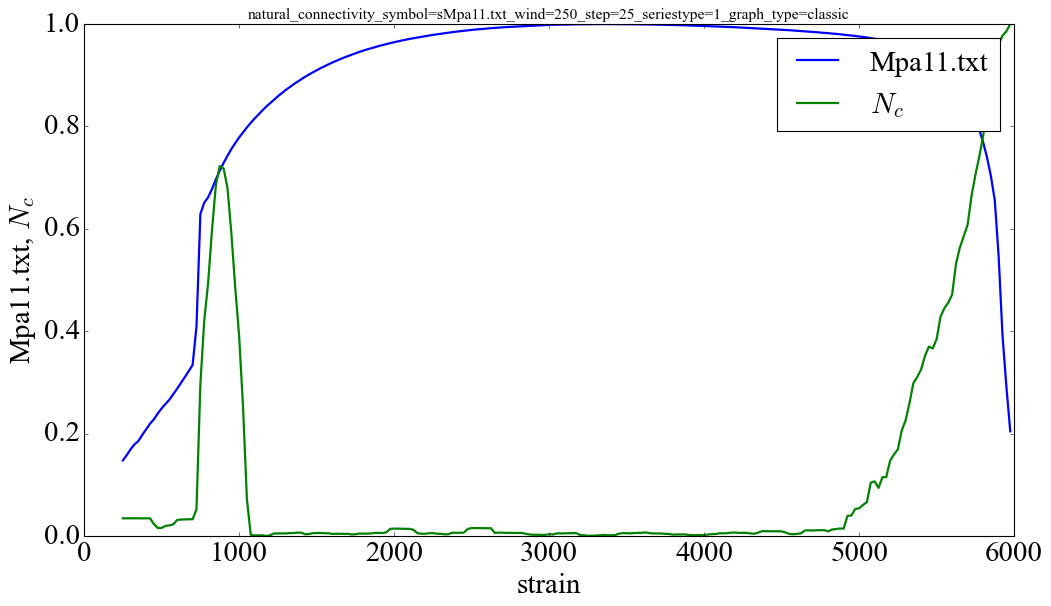

In [24]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Natural_connectivity, label=r'$N_{c}$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$N_{c}$")
ax.set_title(f"natural_connectivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"natural_connectivity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Centrality

In [25]:
DegreeMax = []
GlobalEigenvectorCentrality = []
GlobalClosenessCentrality = []
GlobalInformationCentrality = []
GlobalBetweennessCentrality = []
GlobalLoadCentrality = []
GlobalHarmonicCentrality = []

In [26]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    deg_max = max(dict(nxg.degree()).values())
    glob_eigenvector_centrality = np.mean(list(nx.eigenvector_centrality_numpy(nxg).values()))
    glob_closeness_centrality = np.mean(list(nx.closeness_centrality(nxg).values()))
    glob_information_centrality = np.mean(list(nx.information_centrality(nxg).values()))
    glob_betweenness_centrality = np.mean(list(nx.betweenness_centrality(nxg).values()))
    glob_load_centrality = np.mean(list(nx.load_centrality(nxg).values()))
    glob_harm_centrality = np.mean(list(nx.harmonic_centrality(nxg).values()))

    
    DegreeMax.append(deg_max)
    GlobalEigenvectorCentrality.append(glob_eigenvector_centrality)
    GlobalClosenessCentrality.append(glob_closeness_centrality)
    GlobalInformationCentrality.append(glob_information_centrality)
    GlobalBetweennessCentrality.append(glob_betweenness_centrality)
    GlobalLoadCentrality.append(glob_load_centrality)
    GlobalHarmonicCentrality.append(glob_harm_centrality)



100%|██████████| 230/230 [04:19<00:00,  1.13s/it]


In [27]:
np.savetxt(f"DegreeMax_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", DegreeMax)
np.savetxt(f"GlobalEigenvectorCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalEigenvectorCentrality)
np.savetxt(f"GlobalClosenessCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalClosenessCentrality)
np.savetxt(f"GlobalInformationCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalInformationCentrality)
np.savetxt(f"GlobalBetweennessCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalBetweennessCentrality)
np.savetxt(f"GlobalLoadCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalLoadCentrality)
np.savetxt(f"GlobalHarmonicCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalHarmonicCentrality)

In [28]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо


scaled_DegreeMax = min_max_scaler.fit_transform(np.asarray(DegreeMax).reshape(-1, 1))
scaled_GlobalEigenvectorCentrality = min_max_scaler.fit_transform(np.asarray(GlobalEigenvectorCentrality).reshape(-1, 1))
scaled_GlobalClosenessCentrality = min_max_scaler.fit_transform(np.asarray(GlobalClosenessCentrality).reshape(-1, 1))
scaled_GlobalInformationCentrality = min_max_scaler.fit_transform(np.asarray(GlobalInformationCentrality).reshape(-1, 1))
scaled_GlobalBetweennessCentrality = min_max_scaler.fit_transform(np.asarray(GlobalBetweennessCentrality).reshape(-1, 1))
scaled_GlobalLoadCentrality = min_max_scaler.fit_transform(np.asarray(GlobalLoadCentrality).reshape(-1, 1))
scaled_GlobalHarmonicCentrality = min_max_scaler.fit_transform(np.asarray(GlobalHarmonicCentrality).reshape(-1, 1))

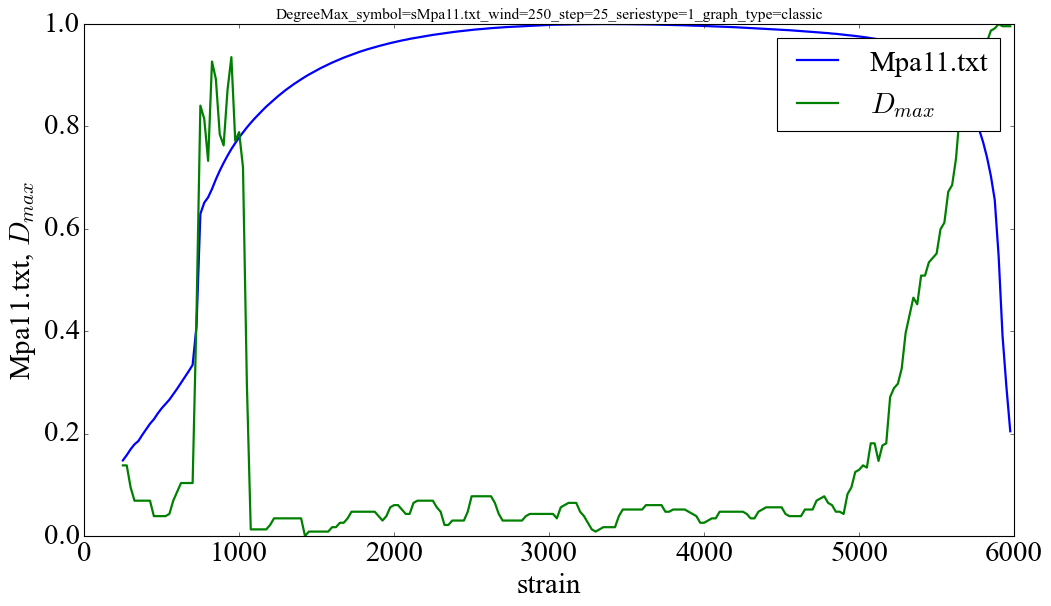

In [29]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_DegreeMax, label=r'$D_{max}$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$D_{max}$")
ax.set_title(f"DegreeMax_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"DegreeMax, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

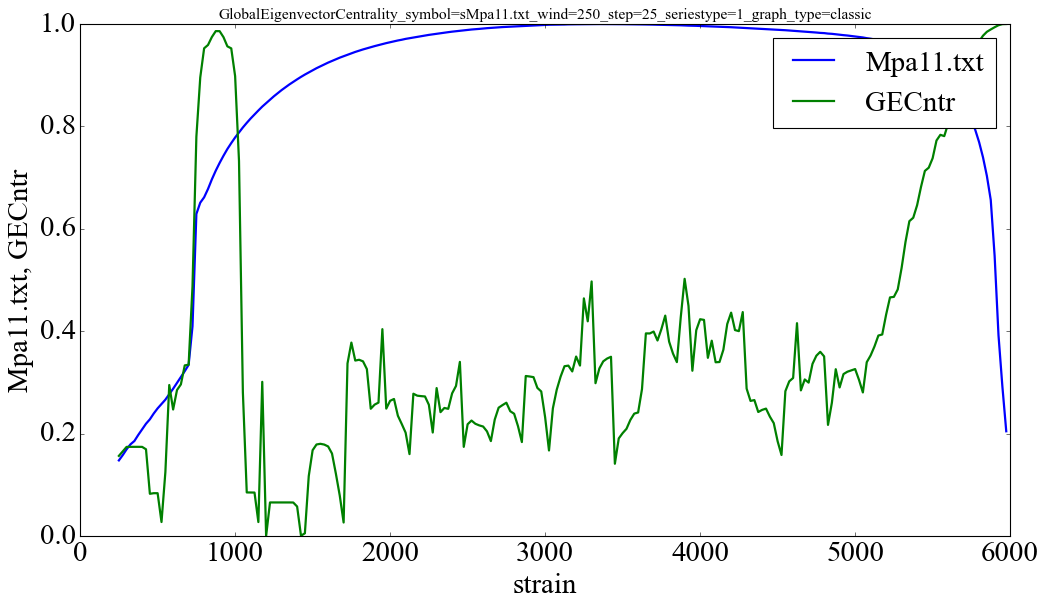

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_GlobalEigenvectorCentrality, label='GECntr')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "GECntr")
ax.set_title(f"GlobalEigenvectorCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"GlobalEigenvectorCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

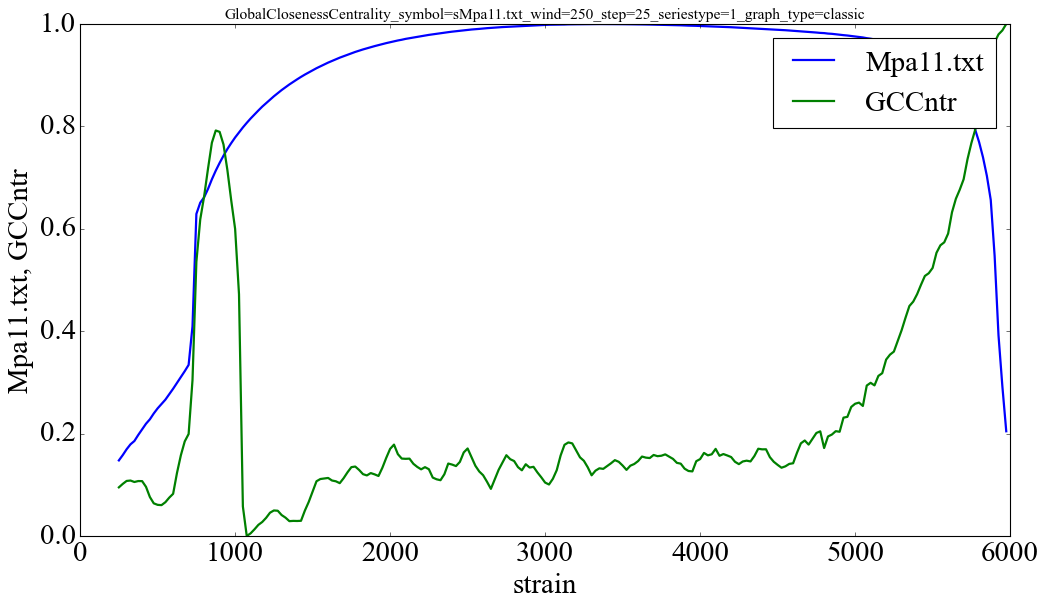

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_GlobalClosenessCentrality, label='GCCntr')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "GCCntr")
ax.set_title(f"GlobalClosenessCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"GlobalClosenessCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

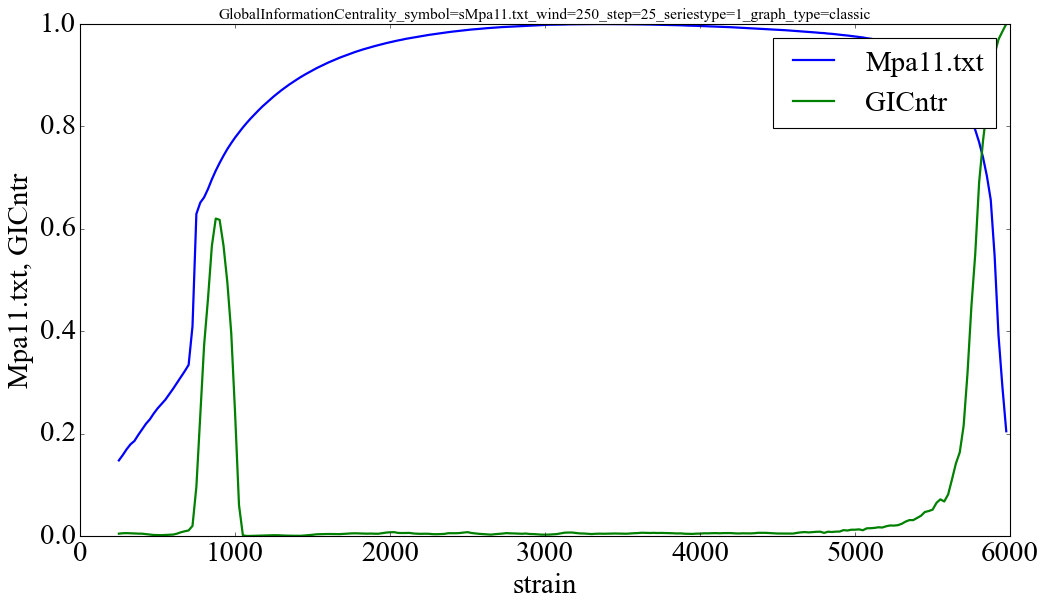

In [32]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_GlobalInformationCentrality, label='GICntr')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "GICntr")
ax.set_title(f"GlobalInformationCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"GlobalInformationCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

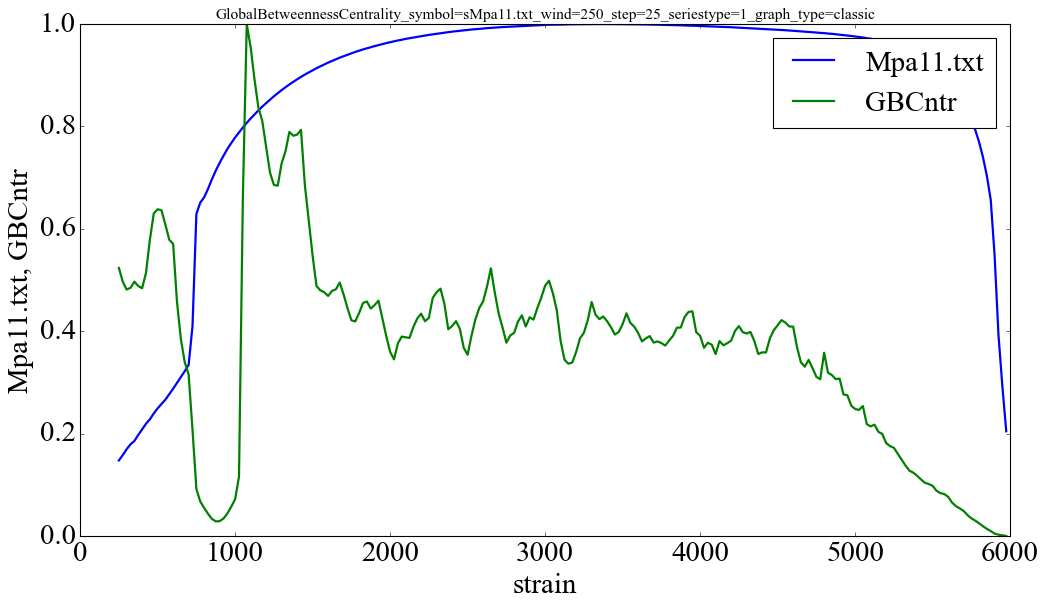

In [33]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_GlobalBetweennessCentrality, label='GBCntr')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "GBCntr")
ax.set_title(f"GlobalBetweennessCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"GlobalBetweennessCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

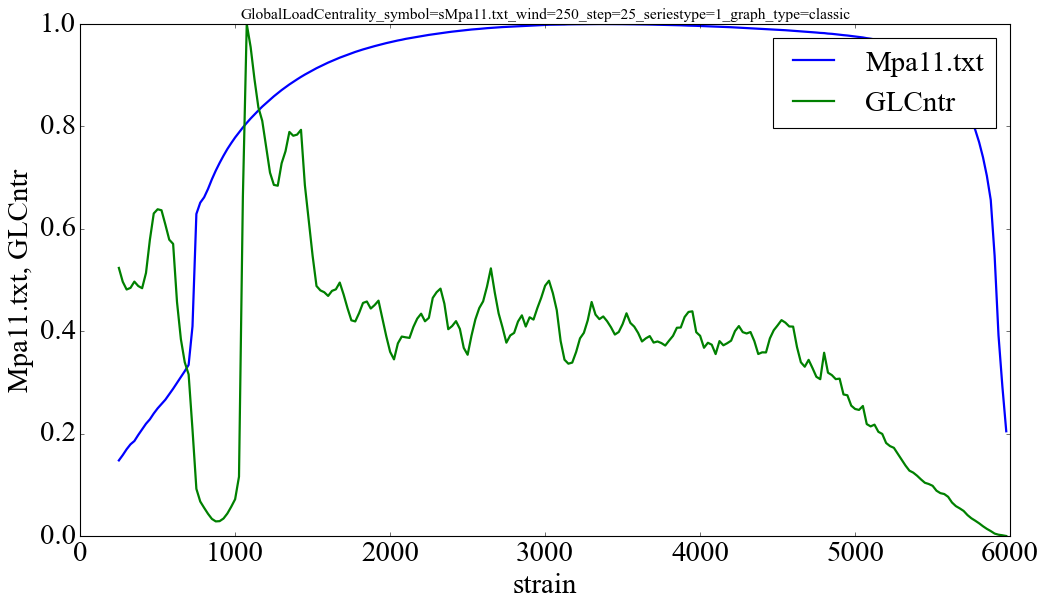

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_GlobalLoadCentrality, label='GLCntr')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "GLCntr")
ax.set_title(f"GlobalLoadCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"GlobalLoadCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

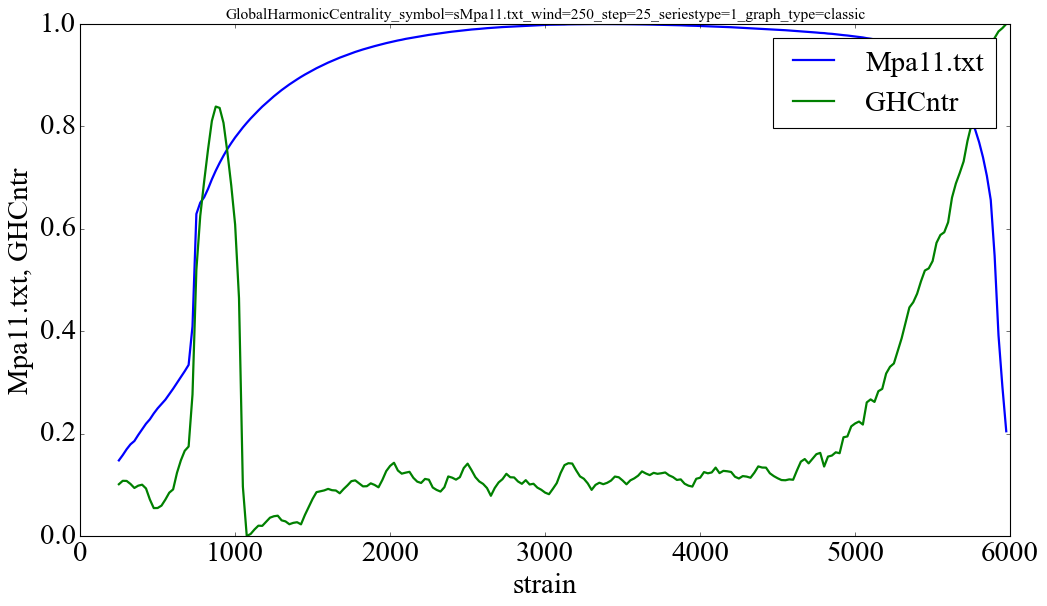

In [35]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_GlobalHarmonicCentrality, label='GHCntr')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "GHCntr")
ax.set_title(f"GlobalHarmonicCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"GlobalHarmonicCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)

## Assortativity

In [36]:
Assortativity = []

In [37]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g_dir = NaturalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    elif graph_type == 'horizontal':
        g_dir = HorizontalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg_dir = nx.DiGraph(g)

    
    assort = nx.degree_pearson_correlation_coefficient(nxg_dir)

    Assortativity.append(assort)

100%|██████████| 230/230 [00:02<00:00, 87.19it/s] 


In [38]:
np.savetxt(f"Assortativity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Assortativity)

In [39]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо


scaled_Assortativity = min_max_scaler.fit_transform(np.asarray(Assortativity).reshape(-1, 1))

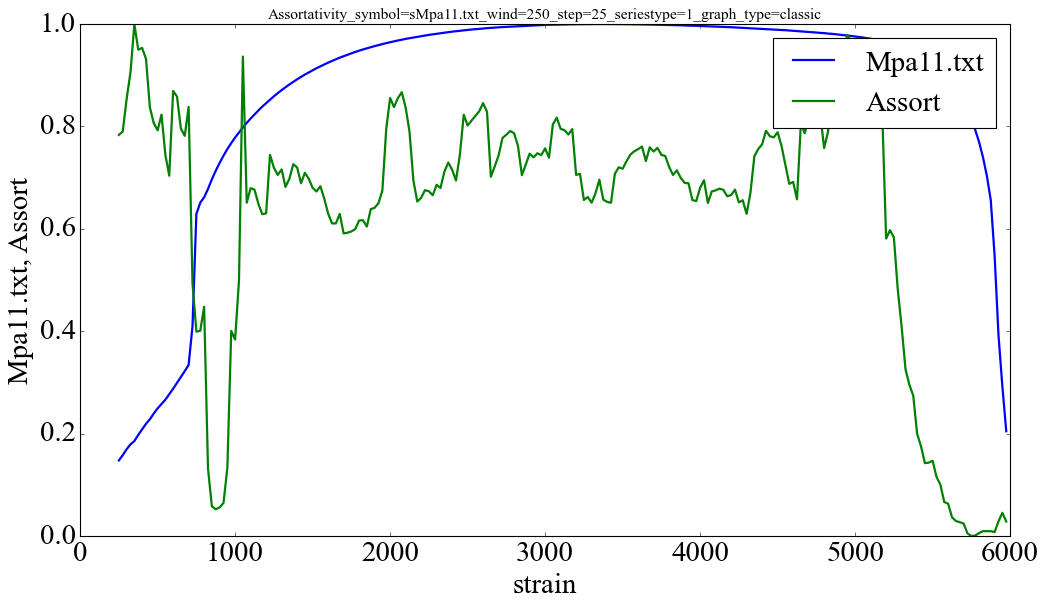

In [40]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Assortativity, label='Assort')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "Assort")
ax.set_title(f"Assortativity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"Assortativity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Clustering

In [41]:
Transitivity = []
AvgClustering = []
AvgSquareClustering = []

In [42]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg = g

    trans = nx.transitivity(nxg)
    avg_clust = nx.average_clustering(nxg)
    avg_sqr_clust = np.mean(list(nx.square_clustering(nxg).values()))
    
    Transitivity.append(trans)
    AvgClustering.append(avg_clust)
    AvgSquareClustering.append(avg_sqr_clust)
    

100%|██████████| 230/230 [25:46<00:00,  6.72s/it] 


In [43]:
np.savetxt(f"AvgClustering_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AvgClustering)
np.savetxt(f"Transitivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Transitivity)
np.savetxt(f"AvgSquareClustering_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Transitivity)

In [44]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

scaled_AvgClustering = min_max_scaler.fit_transform(np.asarray(AvgClustering).reshape(-1, 1))
scaled_Transitivity = min_max_scaler.fit_transform(np.asarray(Transitivity).reshape(-1, 1))
scaled_AvgSquareClustering = min_max_scaler.fit_transform(np.asarray(AvgSquareClustering).reshape(-1, 1))

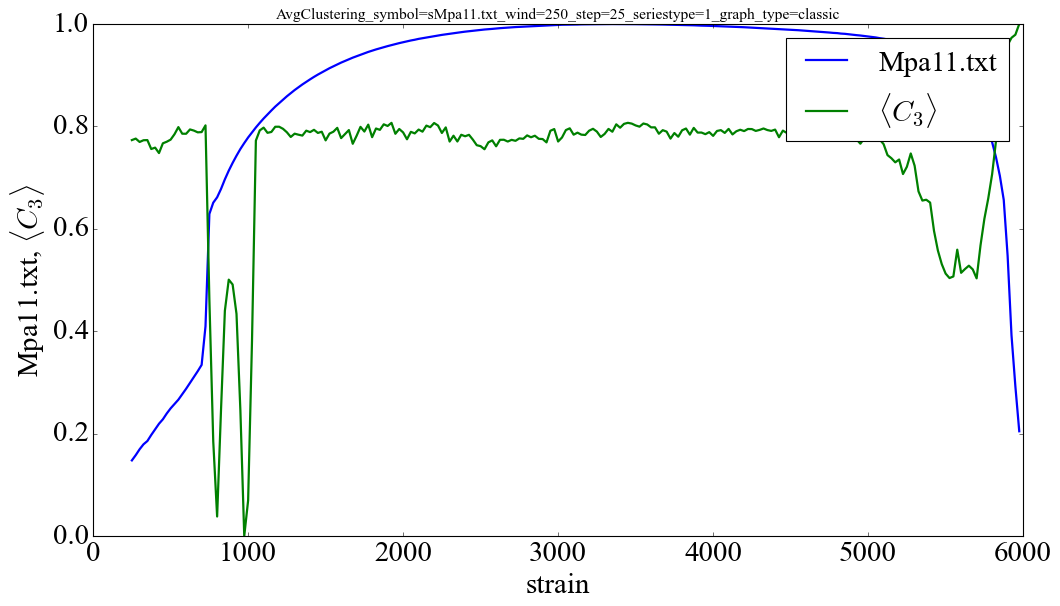

In [45]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_AvgClustering, label=r'$\langle C_{3} \rangle$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$\langle C_{3} \rangle$")
ax.set_title(f"AvgClustering_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"AvgClustering, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

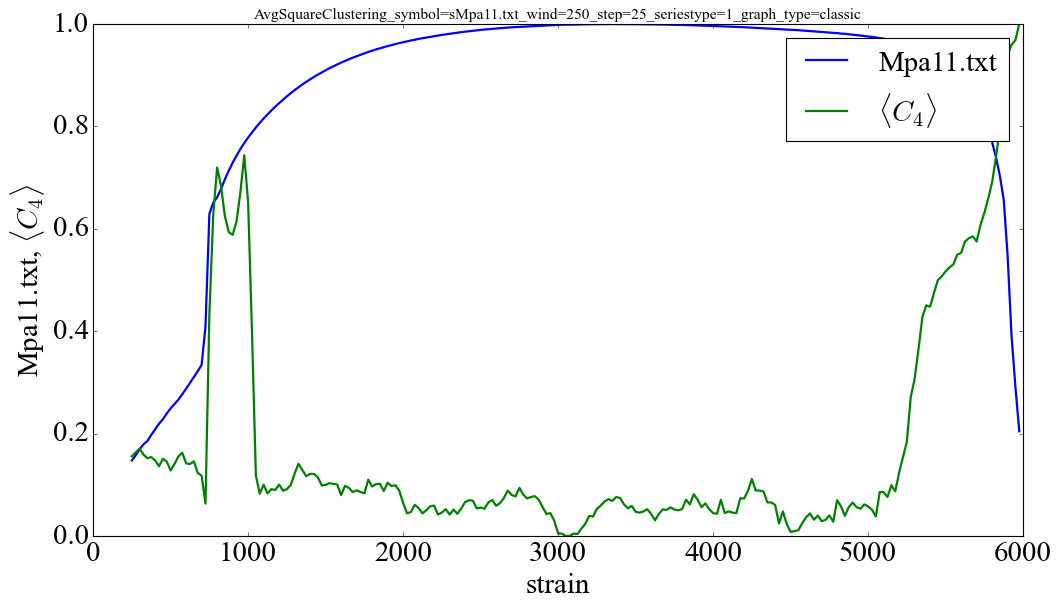

In [46]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_AvgSquareClustering, label=r'$\langle C_{4} \rangle$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$\langle C_{4} \rangle$")
ax.set_title(f"AvgSquareClustering_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"AvgSquareClustering, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

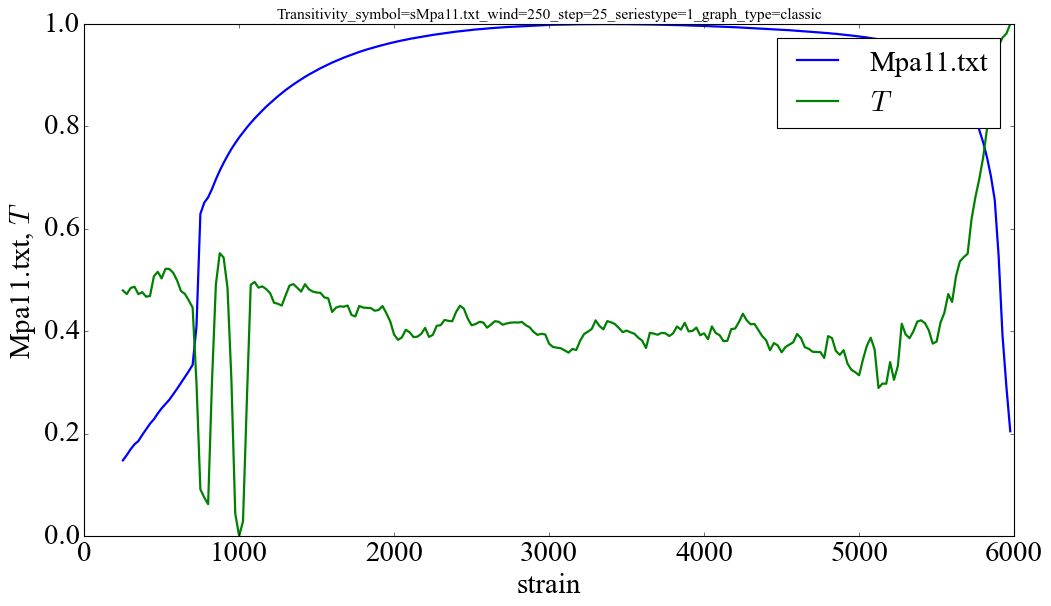

In [47]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Transitivity, label=r'$T$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$T$")
ax.set_title(f"Transitivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"Transitivity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)

## Connectivity

In [48]:
AvgDegreeConnectivity = []

In [49]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g_dir = NaturalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    elif graph_type == 'horizontal':
        g_dir = HorizontalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg_dir = nx.DiGraph(g)
    

    avg_deg_con = np.mean(list(nx.average_degree_connectivity(nxg_dir).values()))
    

    AvgDegreeConnectivity.append(avg_deg_con)

100%|██████████| 230/230 [00:01<00:00, 127.84it/s]


In [50]:
nk.complexity_embedding(fragm, dimension=3, delay=1)

array([[ 91.53490535,  91.61651803,  91.70686309],
       [ 91.61651803,  91.70686309,  91.79143167],
       [ 91.70686309,  91.79143167,  91.86701013],
       [ 91.79143167,  91.86701013,  91.95004601],
       [ 91.86701013,  91.95004601,  92.04927474],
       [ 91.95004601,  92.04927474,  92.13053325],
       [ 92.04927474,  92.13053325,  92.22089158],
       [ 92.13053325,  92.22089158,  92.29433354],
       [ 92.22089158,  92.29433354,  92.38366885],
       [ 92.29433354,  92.38366885,  92.48383874],
       [ 92.38366885,  92.48383874,  92.57046514],
       [ 92.48383874,  92.57046514,  92.66037857],
       [ 92.57046514,  92.66037857,  92.7318588 ],
       [ 92.66037857,  92.7318588 ,  92.84840271],
       [ 92.7318588 ,  92.84840271,  92.93498571],
       [ 92.84840271,  92.93498571,  93.02532979],
       [ 92.93498571,  93.02532979,  93.11556238],
       [ 93.02532979,  93.11556238,  93.20746768],
       [ 93.11556238,  93.20746768,  93.3098965 ],
       [ 93.20746768,  93.30989

In [51]:
np.savetxt(f"AvgDegreeConnectivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AvgDegreeConnectivity)

In [52]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

scaled_AvgDegreeConnectivity = min_max_scaler.fit_transform(np.asarray(AvgDegreeConnectivity).reshape(-1, 1))

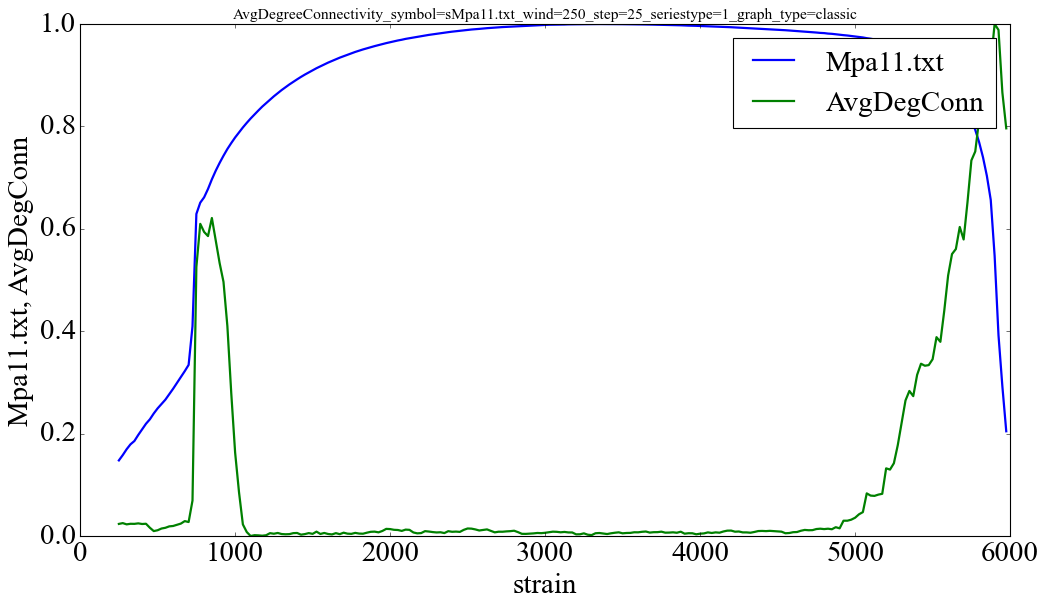

In [53]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_AvgDegreeConnectivity, label='AvgDegConn')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "AvgDegConn")
ax.set_title(f"AvgDegreeConnectivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"AvgDegreeConnectivity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Edges 

In [54]:
Density = []

In [55]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    dens = nx.density(nxg)
   

    Density.append(dens)

100%|██████████| 230/230 [00:01<00:00, 209.01it/s]


In [56]:
np.savetxt(f"Density_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Density)

In [57]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

scaled_Density = min_max_scaler.fit_transform(np.asarray(Density).reshape(-1, 1))

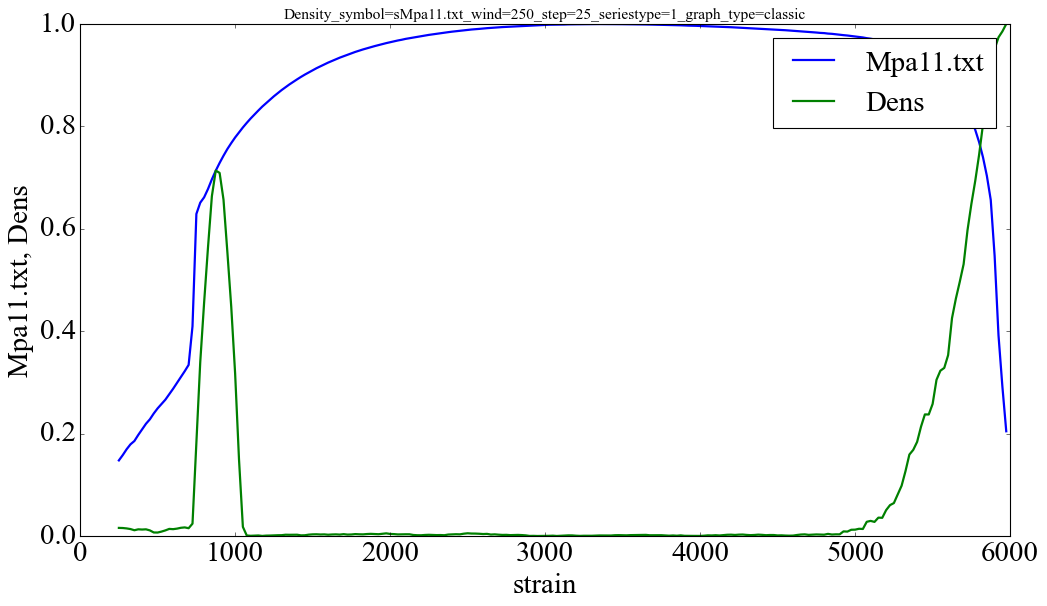

In [58]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Density, label=r'Dens')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"Dens")
ax.set_title(f"Density_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"Density, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Distance measures

In [59]:
Diameter = []
Radius = []

In [60]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    diameter = nx.diameter(nxg)
    rad = nx.radius(nxg)
    
    Diameter.append(diameter)
    Radius.append(rad)

100%|██████████| 230/230 [00:41<00:00,  5.59it/s]


In [61]:
np.savetxt(f"Diameter_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Diameter)
np.savetxt(f"Radius_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Radius)

In [62]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо


scaled_Diameter = min_max_scaler.fit_transform(np.asarray(Diameter).reshape(-1, 1))
scaled_Radius = min_max_scaler.fit_transform(np.asarray(Radius).reshape(-1, 1))

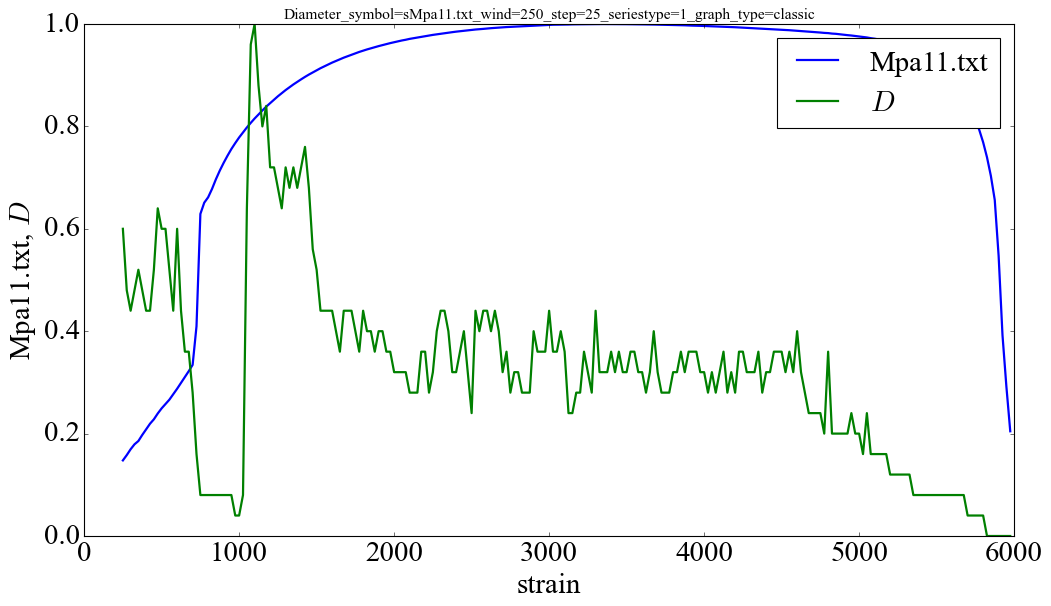

In [63]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Diameter, label=r'$D$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$D$")
ax.set_title(f"Diameter_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"Diameter, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

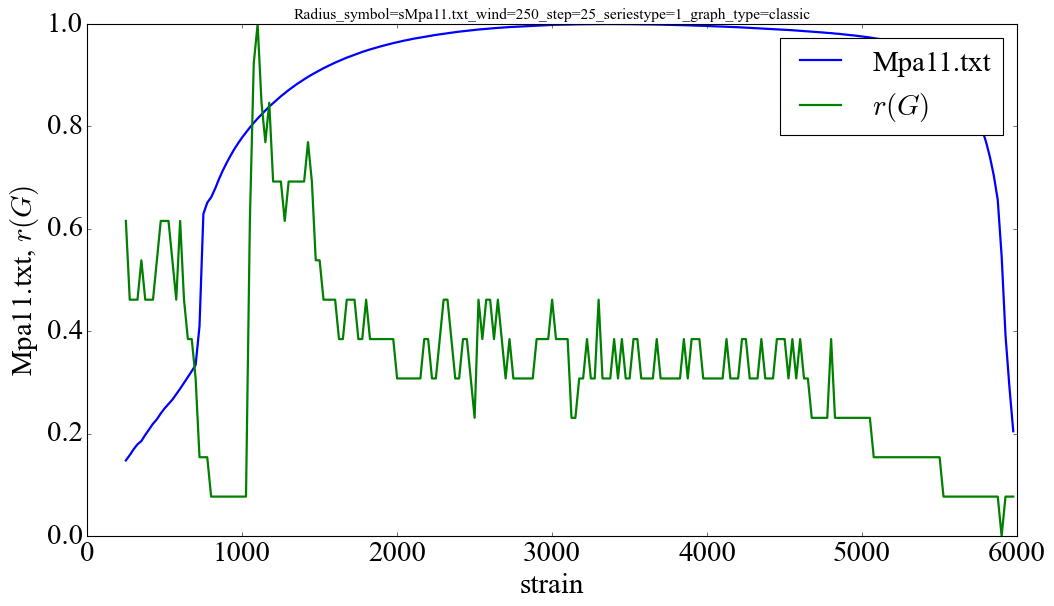

In [64]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_Radius, label=r'$r(G)$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$r(G)$")
ax.set_title(f"Radius_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"Radius, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Efficiency

In [68]:
LocalEfficiency = []
GlobalEfficiency = []

In [69]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    local_eff = nx.local_efficiency(nxg)
    glob_eff = nx.global_efficiency(nxg)
    
    LocalEfficiency.append(local_eff)
    GlobalEfficiency.append(glob_eff)

100%|██████████| 234/234 [22:43<00:00,  5.83s/it] 


In [70]:
np.savetxt(f"LocalEfficiency_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", LocalEfficiency)
np.savetxt(f"GlobalEfficiency_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalEfficiency)

In [71]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо


scaled_LocalEfficiency = min_max_scaler.fit_transform(np.asarray(LocalEfficiency).reshape(-1, 1))
scaled_GlobalEfficiency = min_max_scaler.fit_transform(np.asarray(GlobalEfficiency).reshape(-1, 1))

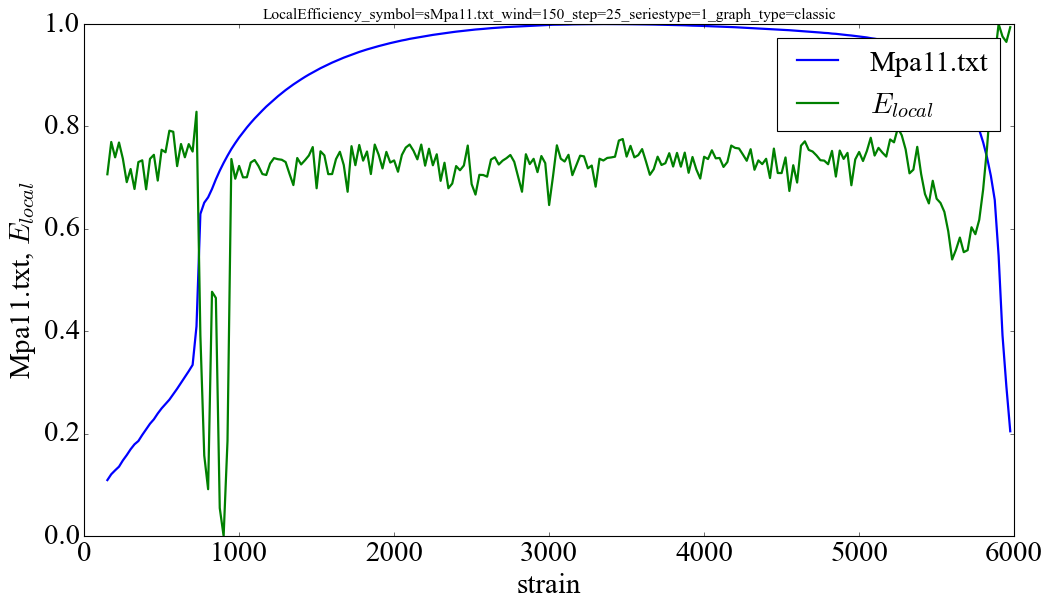

In [72]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_LocalEfficiency, label=r'$E_{local}$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$E_{local}$")
ax.set_title(f"LocalEfficiency_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"LocalEfficiency, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

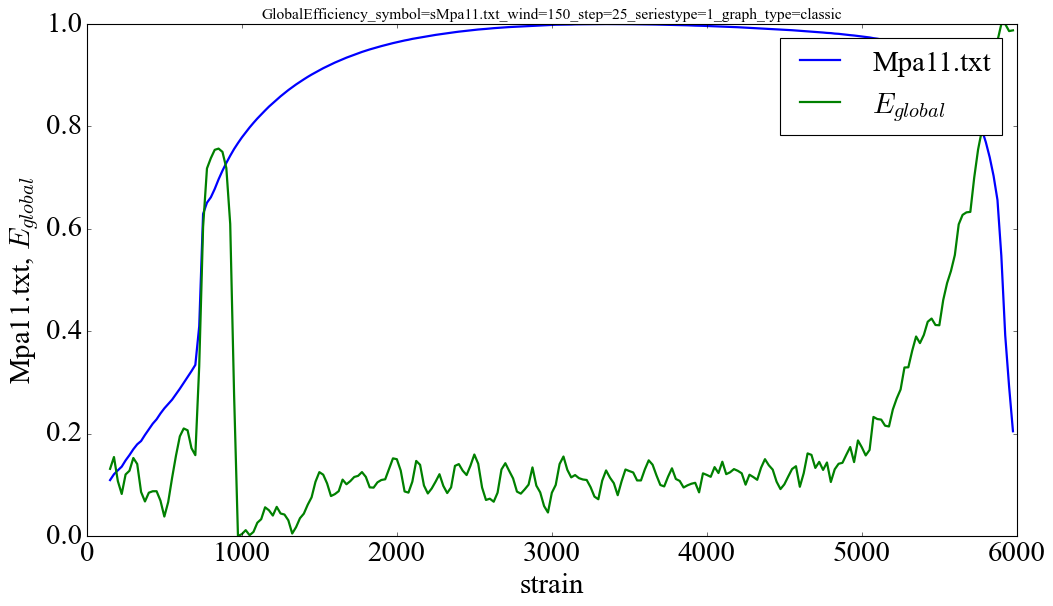

In [73]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_GlobalEfficiency, label=r'$E_{global}$')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + r"$E_{global}$")
ax.set_title(f"GlobalEfficiency_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"GlobalEfficiency, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Shortest path

In [74]:
AvgPathLength = []

In [75]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps*np.abs(np.std(fragm)), dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    

    avg_path_len = nx.average_shortest_path_length(nxg)
   
    AvgPathLength.append(avg_path_len)

100%|██████████| 234/234 [00:07<00:00, 31.69it/s]


In [76]:
np.savetxt(f"AvgPathLength_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AvgPathLength)

In [77]:
min_max_scaler = preprocessing.MinMaxScaler()


scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

scaled_AvgPathLength = min_max_scaler.fit_transform(np.asarray(AvgPathLength).reshape(-1, 1))

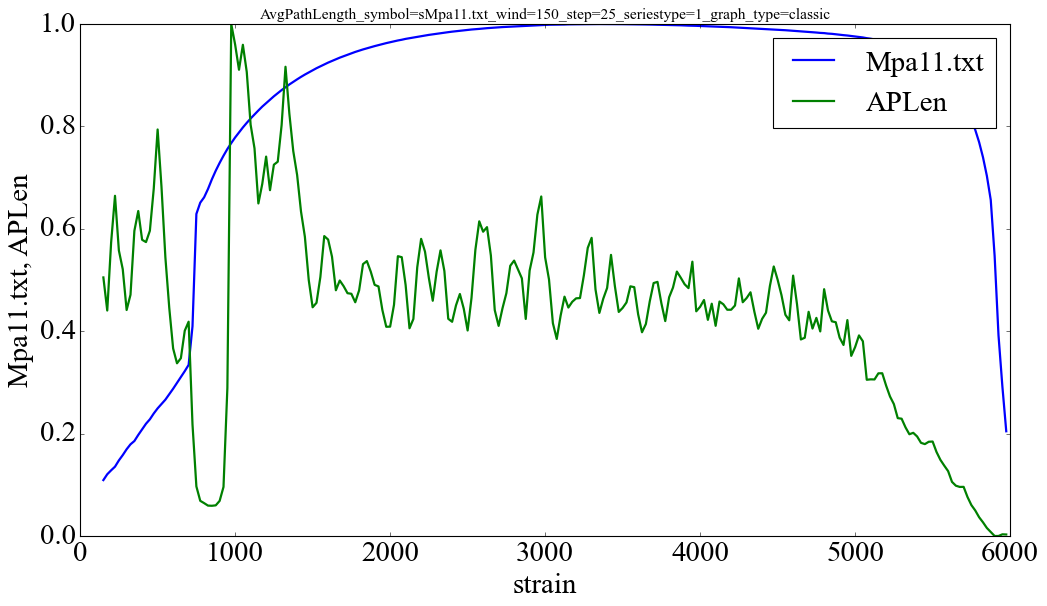

In [78]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=f'{symbol_for_graph}')
ax.plot(time_ser.index[window:length:tstep], scaled_AvgPathLength, label=r'APLen')
ax.set_xlabel(xlabel)
ax.set_ylabel(f"{symbol_for_graph}, " + "APLen")
ax.set_title(f"AvgPathLength_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}", fontsize=14)
ax.legend()

plt.savefig(f"AvgPathLength, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()